Import the libraries

In [2]:
!unzip "/content/drive/MyDrive/Activity.zip"

Streaming output truncated to the last 5000 lines.
  inflating: UCF50/HorseRace/v_HorseRace_g08_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g08_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g08_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g08_c07.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c01.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c01.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c01.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c05.avi  
  inflating: U

In [3]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.4 MB/s eta 0:00:00
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-qqf63ur5/pafy_2e28ba7f0ec64fc8a06d9469a4ea2ad3
  Running command git clone --filter=blob:none --quiet https://github.com/TahaAnwar/pafy.git /tmp/pip-install-qqf63ur5/pafy_2e28ba7f0ec64fc8a06d9469a4ea2ad3
  Resolved https://github.com/TahaAnwar/pafy.git to commit 2f3c473b3df7961721d07e1504675313afd1d2cb
  Preparing metadata (setup.py) ... done
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=35693 sha256=7cc02e3fb299d12a77fc551b68cee6d9e7092e8abdc25d787acdc713b9863391
  Stored in directory: /tmp/pip-ephem-wheel-cache-6_y6ear8/wheels/38/75/72/035d5f91837fe6fdd9ee6ec71eadaf7829068a58f4789a63cc
Successfully built pafy


In [4]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Setting numpy,tf,python seeds to get consistent results on each execution

Visualize data with its labels

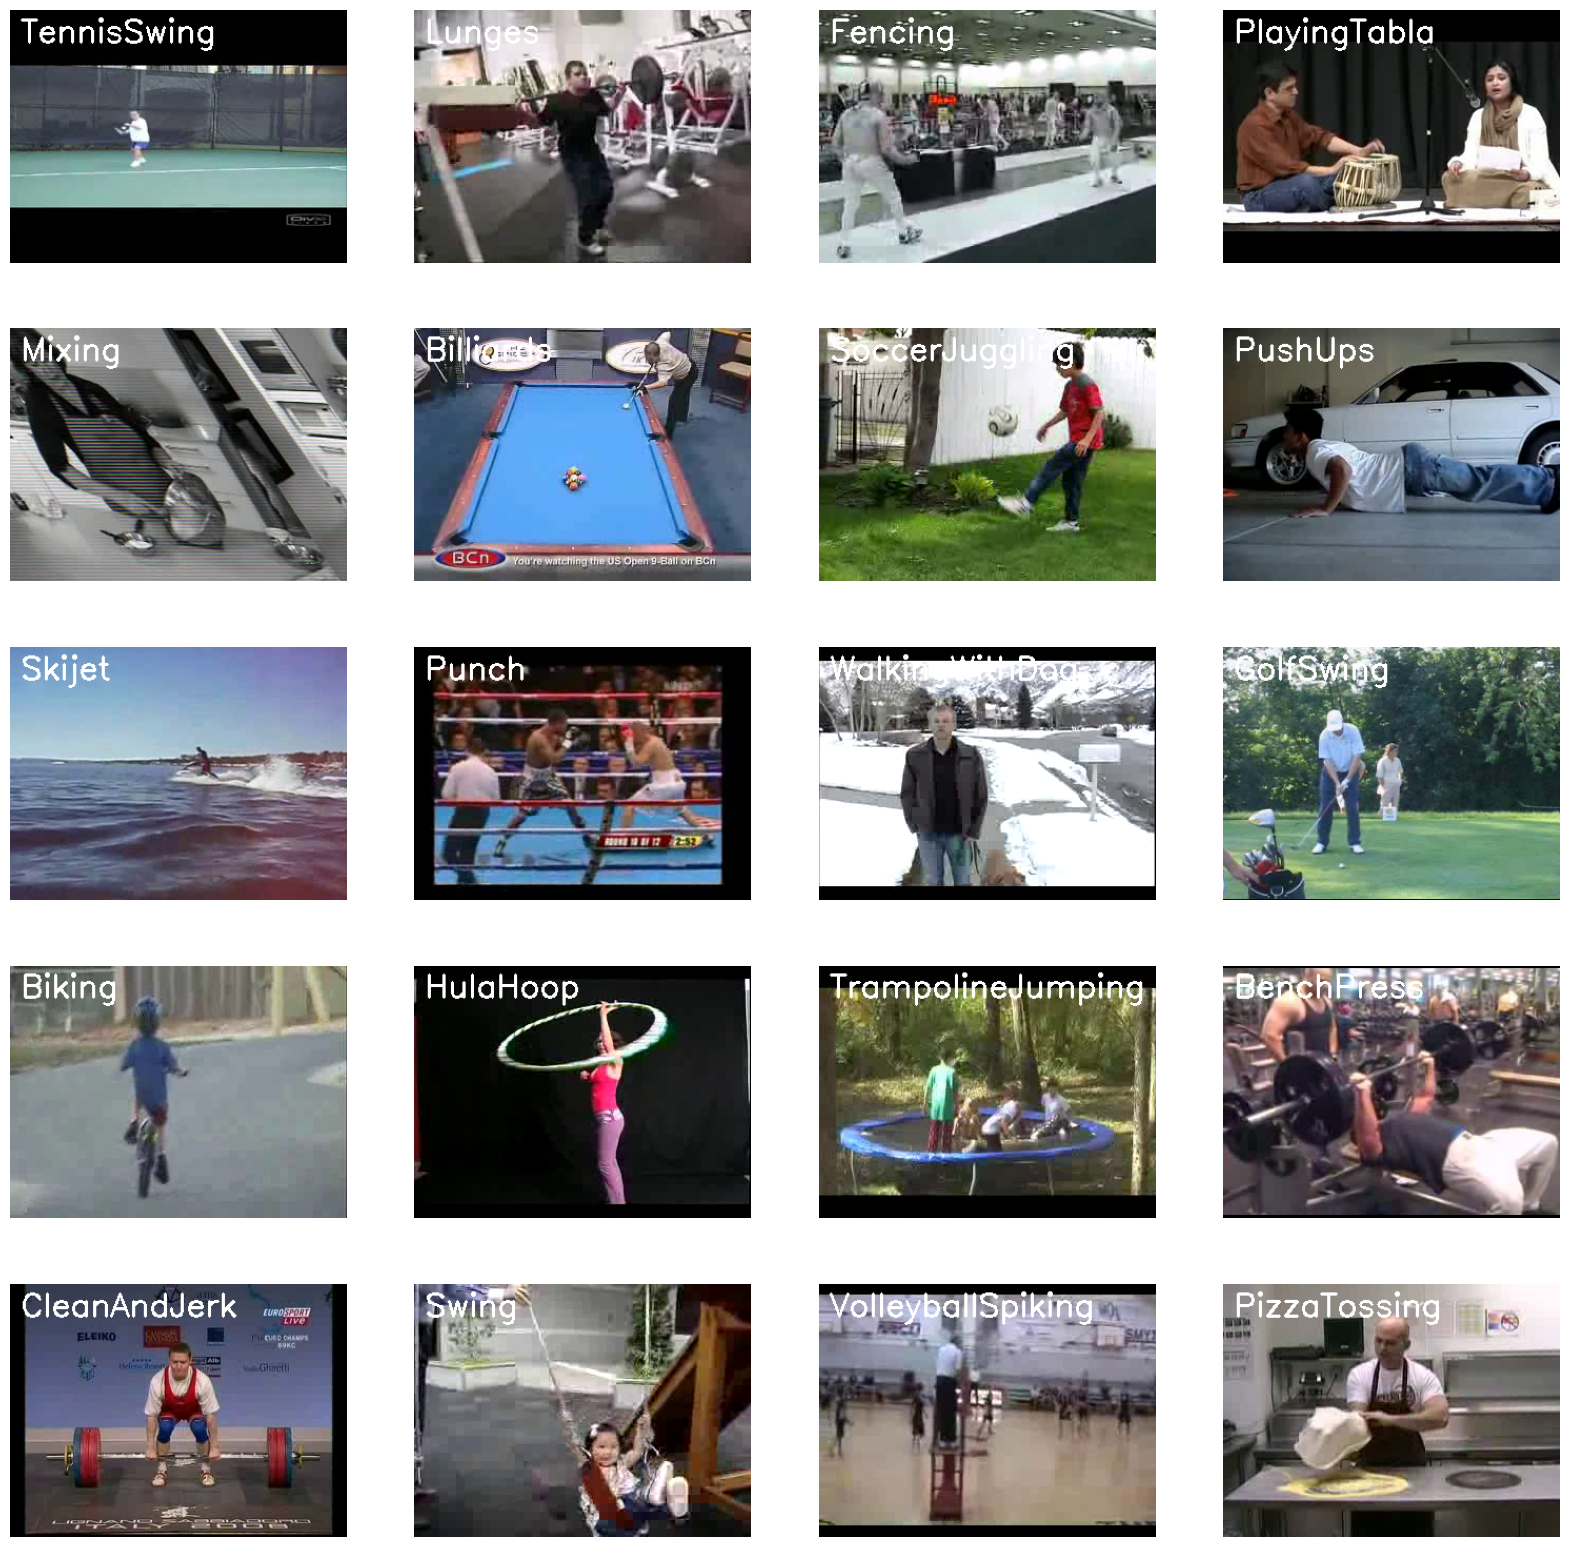

In [6]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('/content/UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'/content/UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'/content/UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

Preprocess the dataset

In [40]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "/content/UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["BenchPress", "CleanAndJerk", "Fencing", "HulaHoop","JumpRope","JumpingJack"]

Function to extract, resize and normalize frames

In [41]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

Function for dataset creation

In [42]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [43]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: BenchPress
Extracting Data of Class: CleanAndJerk
Extracting Data of Class: Fencing
Extracting Data of Class: HulaHoop
Extracting Data of Class: JumpRope
Extracting Data of Class: JumpingJack


In [44]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

Splitting the data into train and test set

In [45]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = 27)

Implementing LRCN model

In [46]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [53]:
# Construct the required LRCN model.
LRCN_model1 = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeD  (None, 20, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, 20, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, 20, 4, 4, 32)     

Checking Model Structure

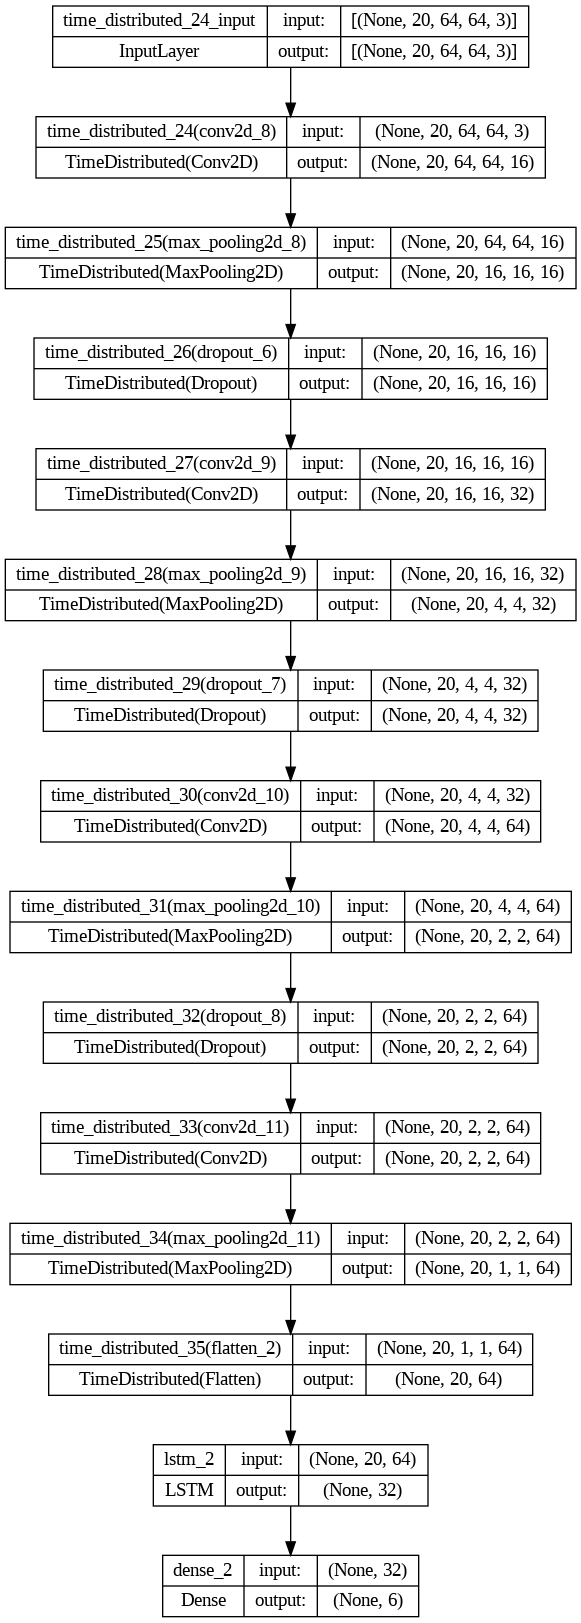

In [54]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model1, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Training and compiling the model

In [56]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model1.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history2 = LRCN_model1.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
117/117 [==============================] - 27s 192ms/step - loss: 1.8035 - accuracy: 0.1799 - val_loss: 1.7756 - val_accuracy: 0.2051
Epoch 2/70
117/117 [==============================] - 27s 228ms/step - loss: 1.7553 - accuracy: 0.2334 - val_loss: 1.7049 - val_accuracy: 0.3248
Epoch 3/70
117/117 [==============================] - 23s 195ms/step - loss: 1.5877 - accuracy: 0.3576 - val_loss: 1.4677 - val_accuracy: 0.4701
Epoch 4/70
117/117 [==============================] - 27s 228ms/step - loss: 1.3283 - accuracy: 0.4668 - val_loss: 1.3967 - val_accuracy: 0.5128
Epoch 5/70
117/117 [==============================] - 23s 196ms/step - loss: 1.1708 - accuracy: 0.5610 - val_loss: 0.9887 - val_accuracy: 0.6752
Epoch 6/70
117/117 [==============================] - 23s 198ms/step - loss: 0.9135 - accuracy: 0.6638 - val_loss: 0.9348 - val_accuracy: 0.6923
Epoch 7/70
117/117 [==============================] - 22s 185ms/step - loss: 0.7066 - accuracy: 0.7452 - val_loss: 0.9053 - val_ac

Evaluating the trained model

In [57]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model1.evaluate(features_test, labels_test)

7/7 [==============================] - 3s 370ms/step - loss: 0.3828 - accuracy: 0.9128


Save the model

In [58]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model1.save(model_file_name)

  saving_api.save_model(



In [37]:
!pip install plot_metric

Plotting loss and accuracy curves

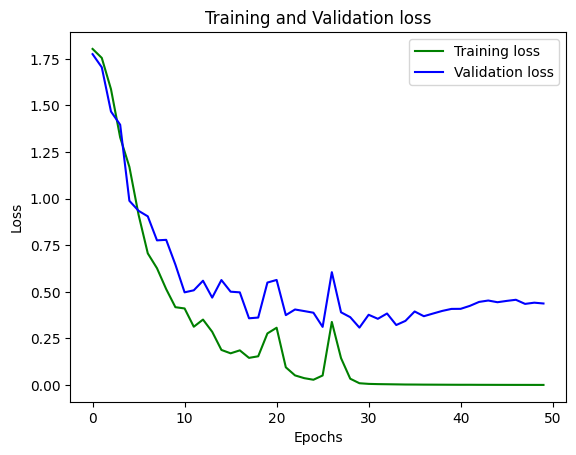

In [67]:
# Visualize the training and validation loss metrices.
# from plot_metric import
# plt(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
# import matplotlib.pyplot as plt
# %matplotlib inline
# #list all data in training
# print(LRCN_model_training_history.params)
# #summarize training for accuracy
# plt.plot(LRCN_model["accuracy"])
# plt.plot(LRCN_model_training_history['val_accuracy'])
# plt.title('Accuracy vs Validation Accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','test'],loc="upper left")
# plt.show()
loss_train = LRCN_model_training_history2.history['loss']
loss_val = LRCN_model_training_history2.history['val_loss']
epochs = range(50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

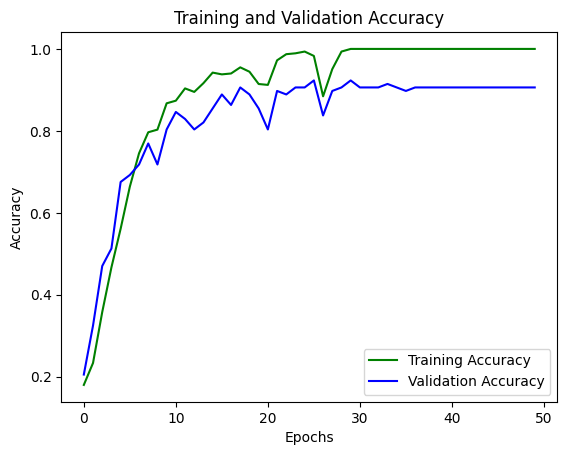

In [68]:
# Visualize the training and validation accuracy metrices.
acc_train = LRCN_model_training_history2.history['accuracy']
acc_val = LRCN_model_training_history2.history['val_accuracy']
epochs = range(50)
plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Testing the model on youtube videos

Prediction function on videos

Function to perform single prediction on video

In [74]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model1.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Release the VideoCapture object.
    video_reader.release()

In [78]:
# Download the youtube video.
# video_title = download_youtube_videos('https://www.youtube.com/watch?v=35Fn5KnXQLU', test_videos_directory)

# Construct tihe nput youtube video path
# input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

# Perform Single Prediction on the Test Video.
predict_single_action('/content/UCF50/BenchPress/v_BenchPress_g06_c05.avi', SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip('/content/UCF50/BenchPress/v_BenchPress_g06_c05.avi', audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 37ms/step
Action Predicted: BenchPress
Confidence: 0.9910005927085876
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
